In [3]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import linregress
from scipy.stats import pearsonr
import gmaps
import requests
import gmaps.datasets
import ipywidgets as widgets
import seaborn as sns; sns.set(style='white')
import gmaps.geojson_geometries
from matplotlib.cbook import boxplot_stats


In [4]:
from configMarc import g_key
gmaps.configure(api_key=g_key)

In [5]:
# Study data files
owidCovidData = "Resources/owid-covid-data-20210430.csv"
transparencyData = "Resources/Transparency Index.csv"
RegionData = "Resources/EuropeRegions.csv"

CovidData = pd.read_csv(owidCovidData)
Transparency = pd.read_csv(transparencyData)
Regions = pd.read_csv(RegionData)

CovidData

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85575,ZWE,Africa,Zimbabwe,2021-04-28,38191.0,27.0,30.143,1565.0,0.0,1.429,...,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571
85576,ZWE,Africa,Zimbabwe,2021-04-29,38235.0,44.0,31.000,1567.0,2.0,1.714,...,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571
85577,ZWE,Africa,Zimbabwe,2021-04-30,38257.0,22.0,30.286,1567.0,0.0,1.571,...,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571
85578,ZWE,Africa,Zimbabwe,2021-05-01,38260.0,3.0,28.000,1568.0,1.0,1.714,...,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571


In [10]:
# eliminate extra columns
CovidClean = CovidData.copy()
CovidClean.drop(['new_cases', 'new_cases_smoothed', 'new_deaths', 'new_deaths_smoothed', 'new_cases_per_million', 
                 'new_cases_smoothed_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients', 
                 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 
                 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests', 'total_tests_per_thousand', 
                 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case', 'tests_units', 
                 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations', 'new_vaccinations_smoothed', 
                 'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 'new_vaccinations_smoothed_per_million', 'stringency_index',
                 'median_age', 'aged_65_older', 'aged_70_older', 'extreme_poverty', 'cardiovasc_death_rate',
                 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand', 'life_expectancy',
                 'people_fully_vaccinated_per_hundred'], axis = 1, inplace = True)

# limit to max date
CovidEuro = CovidClean[CovidClean['continent'].isin(['Europe'])]
CovidEuro = CovidEuro[CovidEuro['date'].isin(['2021-04-30'])]
CovidEuro = CovidEuro[~CovidEuro['location'].isin(['Sweden'])]

# rename "Location" to "Country"
CovidEuro.rename(columns={"location":"Country"}, inplace=True)

# rename everything else for ease
CovidEuro.rename(columns={'total_cases_per_million': "CasesPerMil", 'total_deaths_per_million': "DeathsPerMil", "total_cases":"Cases",
                          "total_deaths": "Deaths", "population": "Population", "population_density": "Density","gdp_per_capita": "GDP", 
                          "human_development_index": "HDI"}, inplace=True)

# merge with Transparency (inner join)
CovidEuro = pd.merge(CovidEuro, Transparency, on=["Country"], how="inner")
CovidEuro.drop(['Rank'], axis = 1, inplace = True)

# merge with regions
CovidEuro = pd.merge(CovidEuro, Regions, on = ["Country"], how = "inner")
CovidEuro.drop(['Notes'], axis = 1, inplace = True)

# # drop lines with null values
CovidEuro.dropna(how = "any", inplace = True)


# CovidEuro.to_csv("Resources/CovidWorkingDataEuro.csv", index = False)

CovidEuro

,iso_code,continent,Country,date,Cases,Deaths,CasesPerMil,DeathsPerMil,Population,Density,GDP,HDI,Score,Region
0,ALB,Europe,Albania,2021-04-30,131085.0,2394.0,45550.420,831.885,2877800.0,104.871,11803.431,0.795,36.0,Eastern Europe
1,AUT,Europe,Austria,2021-04-30,618870.0,10205.0,68714.470,1133.083,9006400.0,106.749,45436.686,0.922,76.0,Western Europe
2,BLR,Europe,Belarus,2021-04-30,358738.0,2542.0,37964.421,269.014,9449321.0,46.858,17167.967,0.823,47.0,Eastern Europe
3,BEL,Europe,Belgium,2021-04-30,990229.0,24230.0,85441.053,2090.665,11589616.0,375.564,42658.576,0.931,76.0,Western Europe
4,BIH,Europe,Bosnia and Herzegovina,2021-04-30,198461.0,8551.0,60491.372,2606.365,3280815.0,68.496,11713.895,0.780,35.0,Eastern Europe
5,BGR,Europe,Bulgaria,2021-04-30,404380.0,16399.0,58197.194,2360.096,6948445.0,65.180,18563.307,0.816,44.0,Eastern Europe
6,HRV,Europe,Croatia,2021-04-30,332183.0,7081.0,80916.276,1724.857,4105268.0,73.726,22669.797,0.851,47.0,Eastern Europe
7,CYP,Europe,Cyprus,2021-04-30,65233.0,308.0,74475.482,351.639,875899.0,127.657,32415.132,0.887,57.0,Southern Europe
8,CZE,Europe,Czechia,2021-04-30,1630758.0,29267.0,152279.460,2732.940,10708982.0,137.176,32605.906,0.900,54.0,Eastern Europe
9,DNK,Europe,Denmark,2021-04-30,251249.0,2484.0,43377.105,428.852,5792203.0,136.520,46682.515,0.940,88.0,Northern Europe


In [11]:
EuroSummary = CovidEuro.groupby(['Region']).agg({"Cases": ["sum"],"Deaths": ["sum"], "Population": ["sum"], "Score": ["mean"]}, )
EuroSummary["CasesPerMil"] = round(EuroSummary["Cases"] / (EuroSummary["Population"] / 1000000),2).astype(float)
EuroSummary["DeathsPerMil"] = round(EuroSummary["Deaths"] / (EuroSummary["Population"] / 1000000),2).astype(float)
EuroSummary["Fatality Rate (%)"] = round(EuroSummary["Deaths"] / (EuroSummary["Cases"])*100,2).astype(float)

CovidEuro.to_csv("Resources/EuroSummary.csv", index = False)

EuroSummary


,Cases,Deaths,Population,Score,CasesPerMil,DeathsPerMil,Fatality Rate (%)
,sum,sum,sum,mean,,,
Region,,,,,,,
Eastern Europe,16857684.0,385271.0,320807095.0,46.150000,52547.73,1200.94,2.29
Northern Europe,457499.0,4183.0,17095413.0,83.000000,26761.51,244.69,0.91
Southern Europe,8823781.0,227099.0,129153812.0,56.000000,68319.94,1758.36,2.57
Western Europe,17623567.0,383711.0,271766915.0,77.444444,64848.10,1411.91,2.18


In [12]:
Eastern = CovidEuro[CovidEuro['Region'].isin(['Eastern Europe'])]
Northern = CovidEuro[CovidEuro['Region'].isin(['Northern Europe'])]
Southern = CovidEuro[CovidEuro['Region'].isin(['Southern Europe'])]
Western = CovidEuro[CovidEuro['Region'].isin(['Western Europe'])]

Eastern

,iso_code,continent,Country,date,Cases,Deaths,CasesPerMil,DeathsPerMil,Population,Density,GDP,HDI,Score,Region
0,ALB,Europe,Albania,2021-04-30,131085.0,2394.0,45550.420,831.885,2877800.0,104.871,11803.431,0.795,36.0,Eastern Europe
2,BLR,Europe,Belarus,2021-04-30,358738.0,2542.0,37964.421,269.014,9449321.0,46.858,17167.967,0.823,47.0,Eastern Europe
4,BIH,Europe,Bosnia and Herzegovina,2021-04-30,198461.0,8551.0,60491.372,2606.365,3280815.0,68.496,11713.895,0.780,35.0,Eastern Europe
5,BGR,Europe,Bulgaria,2021-04-30,404380.0,16399.0,58197.194,2360.096,6948445.0,65.180,18563.307,0.816,44.0,Eastern Europe
6,HRV,Europe,Croatia,2021-04-30,332183.0,7081.0,80916.276,1724.857,4105268.0,73.726,22669.797,0.851,47.0,Eastern Europe
8,CZE,Europe,Czechia,2021-04-30,1630758.0,29267.0,152279.460,2732.940,10708982.0,137.176,32605.906,0.900,54.0,Eastern Europe
10,EST,Europe,Estonia,2021-04-30,122019.0,1161.0,91982.972,875.210,1326539.0,31.033,29481.252,0.892,75.0,Eastern Europe
15,HUN,Europe,Hungary,2021-04-30,779348.0,27540.0,80674.924,2850.828,9660350.0,108.043,26777.561,0.854,44.0,Eastern Europe
20,LVA,Europe,Latvia,2021-04-30,118558.0,2131.0,62855.410,1129.784,1886202.0,31.212,25063.846,0.866,57.0,Eastern Europe
21,LTU,Europe,Lithuania,2021-04-30,247269.0,3923.0,90831.215,1441.066,2722291.0,45.135,29524.265,0.882,60.0,Eastern Europe


The Pearson correlation between GDP per capita and cases per million is -0.04
The r-squared is: 0.0


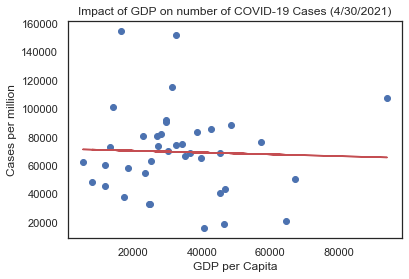

In [13]:
# Calculate the correlation value because why not
correlation = st.pearsonr(CovidEuro["GDP"],CovidEuro["CasesPerMil"])
print(f"The Pearson correlation between GDP per capita and cases per million is {round(correlation[0],2)}")


# Plot
x_values = CovidEuro["GDP"]
y_values = CovidEuro["CasesPerMil"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")

# Label
plt.xlabel('GDP per Capita')
plt.ylabel("Cases per million")
plt.title ("Impact of GDP on number of COVID-19 Cases (4/30/2021)")
print(f"The r-squared is: {round(rvalue**2,2)}")


# Print
plt.savefig("Output/ScatterEuroGDPvsCases.png")

#Display
plt.show()

The Pearson correlation between HDI and cases per million is -0.06
The r-squared is: 0.0


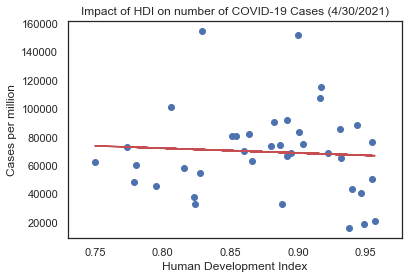

In [14]:
# Calculate the correlation value because why not
correlation = st.pearsonr(CovidEuro["HDI"],CovidEuro["CasesPerMil"])
print(f"The Pearson correlation between HDI and cases per million is {round(correlation[0],2)}")


# Plot
x_values = CovidEuro["HDI"]
y_values = CovidEuro["CasesPerMil"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")

# Label
plt.xlabel('Human Development Index')
plt.ylabel("Cases per million")
plt.title ("Impact of HDI on number of COVID-19 Cases (4/30/2021)")
print(f"The r-squared is: {round(rvalue**2,2)}")


# Print
plt.savefig("Output/ScatterEuroHDIvsCases.png")

#Display
plt.show()

The Pearson correlation between corruption perception and cases per million is -0.09
The r-squared is: 0.01


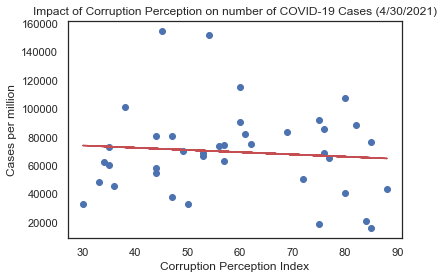

In [15]:
# Calculate the correlation value because why not
correlation = st.pearsonr(CovidEuro["Score"],CovidEuro["CasesPerMil"])
print(f"The Pearson correlation between corruption perception and cases per million is {round(correlation[0],2)}")


# Plot
x_values = CovidEuro["Score"]
y_values = CovidEuro["CasesPerMil"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")

# Label
plt.xlabel('Corruption Perception Index')
plt.ylabel("Cases per million")
plt.title ("Impact of Corruption Perception on number of COVID-19 Cases (4/30/2021)")
print(f"The r-squared is: {round(rvalue**2,2)}")

# Print
plt.savefig("Output/ScatterEuroScoreVsCases.png")

#Display
plt.show()

The Pearson correlation between GDP per capita and deaths per million is -0.29
The r-squared is: 0.08


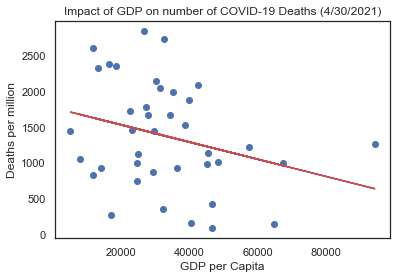

In [16]:
# Calculate the correlation value because why not
correlation = st.pearsonr(CovidEuro["GDP"],CovidEuro["DeathsPerMil"])
print(f"The Pearson correlation between GDP per capita and deaths per million is {round(correlation[0],2)}")


# Plot
x_values = CovidEuro["GDP"]
y_values = CovidEuro["DeathsPerMil"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")

# Label
plt.xlabel('GDP per Capita')
plt.ylabel("Deaths per million")
plt.title ("Impact of GDP on number of COVID-19 Deaths (4/30/2021)")
print(f"The r-squared is: {round(rvalue**2,2)}")


# Print
plt.savefig("Output/ScatterEuroGDPvsDeaths.png")

#Display
plt.show()

The Pearson correlation between HDI and cases per million is -0.31
The r-squared is: 0.02


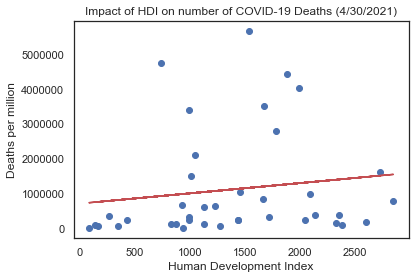

In [17]:
# Calculate the correlation value because why not
correlation = st.pearsonr(CovidEuro["HDI"],CovidEuro["DeathsPerMil"])
print(f"The Pearson correlation between HDI and cases per million is {round(correlation[0],2)}")


# Plot
x_values = CovidEuro["DeathsPerMil"]
y_values = CovidEuro["Cases"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")

# Label
plt.xlabel('Human Development Index')
plt.ylabel("Deaths per million")
plt.title ("Impact of HDI on number of COVID-19 Deaths (4/30/2021)")
print(f"The r-squared is: {round(rvalue**2,2)}")


# Print
plt.savefig("Output/ScatterEuroHDIvsDeaths.png")

#Display
plt.show()

The Pearson correlation between corruption perception and deaths per million is -0.37
The r-squared is: 0.14


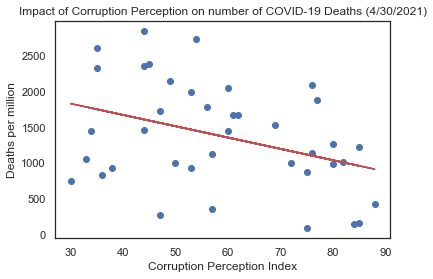

In [18]:
# Calculate the correlation value because why not
correlation = st.pearsonr(CovidEuro["Score"],CovidEuro["DeathsPerMil"])
print(f"The Pearson correlation between corruption perception and deaths per million is {round(correlation[0],2)}")


# Plot
x_values = CovidEuro["Score"]
y_values = CovidEuro["DeathsPerMil"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")

# Label
plt.xlabel('Corruption Perception Index')
plt.ylabel("Deaths per million")
plt.title ("Impact of Corruption Perception on number of COVID-19 Deaths (4/30/2021)")
print(f"The r-squared is: {round(rvalue**2,2)}")


# Print
plt.savefig("Output/ScatterEuroScoreVsDeaths.png")

#Display
plt.show()

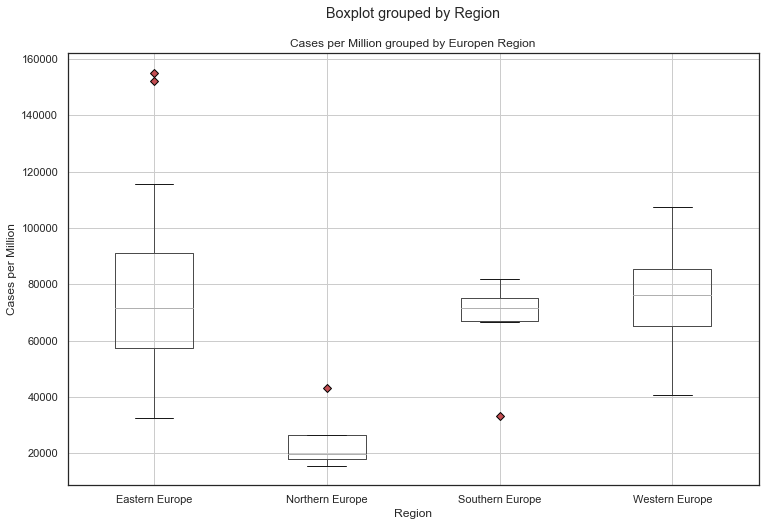

In [19]:
# Marsja, Erik. “Four Ways to Conduct One-Way ANOVA with Python.” Erik Marsja, 19 Nov. 2020, 
# www.marsja.se/four-ways-to-conduct-one-way-anovas-using-python/#:~:text=%20ANOVA%20in%20Python%20using%20Statsmodels%20%201,carry%20out%20the%20ANOVA%20in%20Python%0ASave%20More%20.

# Set up Outlier Markers
red_diamond = dict(markerfacecolor='r', marker='D')

#Create a boxplot
CovidEuro.boxplot('CasesPerMil', by='Region', figsize=(12, 8), flierprops = red_diamond)

# ctrl = CovidEuro['Cases/M'][CovidEuro.Region == 'ctrl']
grps = pd.unique(CovidEuro.Region.values)
d_data = {grp:CovidEuro['CasesPerMil'][CovidEuro.Region == grp] for grp in grps}

k = len(pd.unique(CovidEuro.Region))  # number of conditions
N = len(CovidEuro.values)  # conditions times participants
n = CovidEuro.groupby('Region').size()[0] #Participants in each condition
plt.title ("Cases per Million grouped by Europen Region")
plt.ylabel ("Cases per Million")

# Print
plt.savefig("Output/BoxplotCases.png")

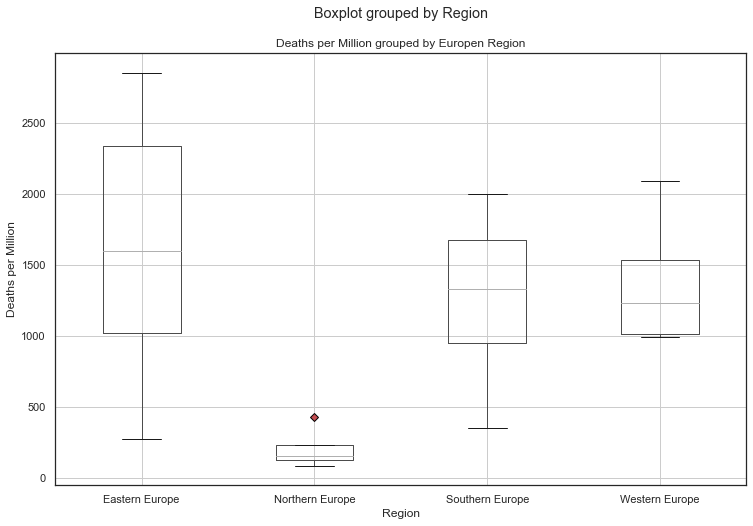

In [20]:
# Marsja, Erik. “Four Ways to Conduct One-Way ANOVA with Python.” Erik Marsja, 19 Nov. 2020, 
# www.marsja.se/four-ways-to-conduct-one-way-anovas-using-python/#:~:text=%20ANOVA%20in%20Python%20using%20Statsmodels%20%201,carry%20out%20the%20ANOVA%20in%20Python%0ASave%20More%20.

# Set up Outlier Markers
red_diamond = dict(markerfacecolor='r', marker='D')


#Create a boxplot
CovidEuro.boxplot('DeathsPerMil', by='Region', figsize=(12, 8), flierprops = red_diamond)

# ctrl = CovidEuro['Cases/M'][CovidEuro.Region == 'ctrl']
grps = pd.unique(CovidEuro.Region.values)
d_data = {grp:CovidEuro['DeathsPerMil'][CovidEuro.Region == grp] for grp in grps}

k = len(pd.unique(CovidEuro.Region))  # number of conditions
N = len(CovidEuro.values)  # conditions times participants
n = CovidEuro.groupby('Region').size()[0] #Participants in each condition
plt.title ("Deaths per Million grouped by Europen Region")
plt.ylabel ("Deaths per Million")

# Print
plt.savefig("Output/BoxplotDeaths.png")

# Going Super ANOVA


## Hypothesis and level of significance
### European regions show no significant difference in COVID-19 related cases or deaths per million of population

#### Ho: North = South = East = West
#### Ha: at least two means are differnt
#### Alpha = 0.05

#### Perform one_way Ananlysis of Variance (ANOVA) test for both Cases and Deaths per Million


In [21]:
# Critical Value Calculation
# population is the total number of countries = 40
# c = number of groups which is 4
# DoF numerator dfn= c-1 or in this case 3
# DoF denominator dfd = n - c or 40-3 or 37
st.f.ppf(q=1-0.05, dfn=3, dfd=37)

2.858796053950291

In [22]:
# perform oneway ANOVA
st.f_oneway(Northern['CasesPerMil'], Southern['CasesPerMil'], Eastern['CasesPerMil'], Western['CasesPerMil'])

F_onewayResult(statistic=4.189555948754347, pvalue=0.012355058346857467)

In [23]:
# perform oneway ANOVA
st.f_oneway(Northern['DeathsPerMil'], Southern['DeathsPerMil'], Eastern['DeathsPerMil'], Western['DeathsPerMil'])

F_onewayResult(statistic=5.9619428323204, pvalue=0.0021471387828259666)

#### Analysis:
Observing our F statistic is more extreme than our critical value for Deaths per Million, Reject Ho and state there is evidence at least two means are different

For Cases per Million, our F statistic is less extreme than our critical value and therefore Ho is accepted.

## Regional T-Tests: Cases

In [25]:
# INDEPENDENT T TEST COMPARES THE MEANS FOR 2 GROUPS
st.ttest_ind(Eastern.Cases, Northern.Cases, equal_var=False)

Ttest_indResult(statistic=1.7560267612367422, pvalue=0.09409122928211959)

In [26]:
# INDEPENDENT T TEST COMPARES THE MEANS FOR 2 GROUPS
st.ttest_ind(Eastern.Cases, Southern.Cases, equal_var=False)

Ttest_indResult(statistic=-0.7987352035481156, pvalue=0.45340999835680884)

In [27]:
# INDEPENDENT T TEST COMPARES THE MEANS FOR 2 GROUPS
st.ttest_ind(Eastern.Cases, Western.Cases, equal_var=False)

Ttest_indResult(statistic=-1.5321474524909329, pvalue=0.15506308077751949)

In [28]:
# INDEPENDENT T TEST COMPARES THE MEANS FOR 2 GROUPS
st.ttest_ind(Northern.Cases, Southern.Cases, equal_var=False)

Ttest_indResult(statistic=-1.5560594402331493, pvalue=0.17455746554601076)

In [29]:
# INDEPENDENT T TEST COMPARES THE MEANS FOR 2 GROUPS
st.ttest_ind(Northern.Cases, Western.Cases, equal_var=False)

Ttest_indResult(statistic=-2.3847070552161584, pvalue=0.0408111120337642)

In [30]:
# INDEPENDENT T TEST COMPARES THE MEANS FOR 2 GROUPS
st.ttest_ind(Western.Cases, Southern.Cases, equal_var=False)

Ttest_indResult(statistic=0.4854248347636007, pvalue=0.6363025012616463)

## Regional T-Tests: Deaths

In [32]:
# INDEPENDENT T TEST COMPARES THE MEANS FOR 2 GROUPS
st.ttest_ind(Eastern.Deaths, Northern.Deaths, equal_var=False)

Ttest_indResult(statistic=2.356769062977063, pvalue=0.027340926205103522)

In [33]:
# INDEPENDENT T TEST COMPARES THE MEANS FOR 2 GROUPS
st.ttest_ind(Eastern.Deaths, Southern.Deaths, equal_var=False)

Ttest_indResult(statistic=-0.8722258296873757, pvalue=0.4170861657045628)

In [34]:
# INDEPENDENT T TEST COMPARES THE MEANS FOR 2 GROUPS
st.ttest_ind(Eastern.Deaths, Western.Deaths, equal_var=False)

Ttest_indResult(statistic=-1.348578785565447, pvalue=0.20632320590398132)

In [35]:
# INDEPENDENT T TEST COMPARES THE MEANS FOR 2 GROUPS
st.ttest_ind(Northern.Deaths, Southern.Deaths, equal_var=False)

Ttest_indResult(statistic=-1.6610597635147588, pvalue=0.15571502305331528)

In [36]:
# INDEPENDENT T TEST COMPARES THE MEANS FOR 2 GROUPS
st.ttest_ind(Northern.Deaths, Western.Deaths, equal_var=False)

Ttest_indResult(statistic=-2.371589211010514, pvalue=0.043649860169314124)

In [37]:
# INDEPENDENT T TEST COMPARES THE MEANS FOR 2 GROUPS
st.ttest_ind(Western.Deaths, Southern.Deaths, equal_var=False)

Ttest_indResult(statistic=0.18342792963518667, pvalue=0.8579067441716164)